# Assignment 2 - MC906: Approximating images with 50 circles using Genetic Algorithm

## Problem modeling:

### Individual: an image with 50 circles

Each circle (gene) has the following parameters:
* left(float): distance to the left normalized between [0.0, 1.0]
* top(float): distance to the top normalized between [0.0, 1.0]
* radius(float): Circle radius
* color(array-like(h,s,v)): Color to be used on render coded as HSV
* alpha(float): Opacity level bound to [0.0, 1.0]

### Population: several sets with 50 circles each


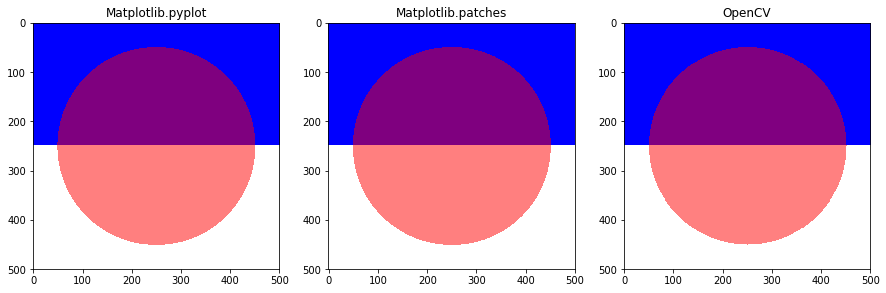

In [2]:
""" Circle plotting comparison """

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat

FILL_CIRCLE = -1

fig, axs = plt.subplots(ncols=3, figsize=(15,5))

images = np.full(shape=(3, 500,500, 3), dtype=np.uint8, fill_value=255)
images[:, :250, :, :2] = 0
xy = (250, 250)
radius = 200
alpha = 0.5
color = (255, 0, 0)
norm_color = tuple(c/255 if c > 1 else c for c in color)

# Matplotlib.pyplot
image, ax = images[0], axs[0]
ax.add_artist(plt.Circle(xy, radius, facecolor=norm_color, alpha=alpha, antialiased=False))
ax.imshow(image)
ax.set_title('Matplotlib.pyplot')

# Matplotlib.patches
image, ax = images[1], axs[1]
ax.add_patch(pat.Circle(xy, radius, facecolor=norm_color, alpha=alpha, antialiased=False))
ax.imshow(image)
ax.set_title('Matplotlib.patches')

# OpenCV
# https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html#circle
image, ax = images[2], axs[2]
circle = np.copy(image)
cv2.circle(circle, center=xy, radius=radius, color=color, thickness=FILL_CIRCLE)
cv2.addWeighted(src1=circle, alpha=alpha, src2=image, beta=1-alpha, gamma=0, dst=image)
ax.imshow(image)
ax.set_title('OpenCV')

# fig.savefig('image', dpi=50)
plt.show()

## Useful links:

Aproximação por triangulos: https://github.com/DING-PENG/image-approx

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

from circle import Circle
from image_from_circles import ImageFromCircles
from individual import Individual
from evolve import Evolve
from utils import rms, plot_image, save_image

image_shape = (600, 800, 3)
plot_image(ImageFromCircles([Circle() for i in range(50)]).render(image_shape))

<Figure size 600x600 with 1 Axes>

## Indivíduos


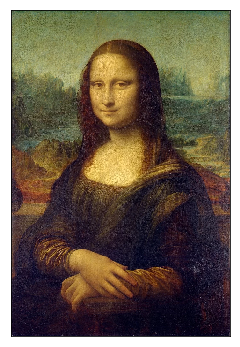

In [2]:
# Read reference image
image = cv2.imread('mona.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convert color loaded by OpenCV
plot_image(image)

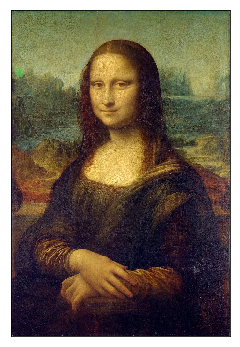

fitness: -8.158004222084871


In [3]:
image_with_circle = np.copy(image)
circle = Circle()
circle.render(image_with_circle)
plot_image(image_with_circle)
print('fitness:', -rms(image, image_with_circle))

fitness: 150.54248042150206


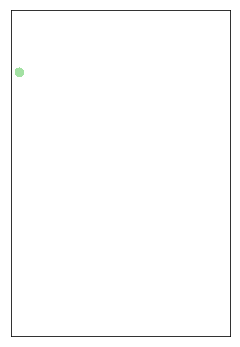

In [4]:
ind = Individual(size=1, circles=[circle])
print('fitness:', ind.update_fitness(image))
plot_image(ind.rendered)

In [ ]:
image = cv2.imread('mona.jpg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convert color loaded by OpenCV

number_generations = 100

generation = Evolve(image, pop_size=50, crossover_rate=0.2, mutation_rate=0.1, individual_size=100)
generation.evaluate()
generation.plot_image()

for i in range(number_generations):
    generation.crossover()
    generation.mutate()
    generation.evaluate()
    generation.plot_image()